# Can we predict if a given pitch will result in a hit?

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pybaseball import statcast #https://github.com/jldbc/pybaseball
from pybaseball import  playerid_lookup
from pybaseball import  statcast_batter

### Inspiration:
1. https://github.com/jwilsonds/swing_probability_model/blob/master/votto%20swing%20probability.ipynb 

In [2]:
#Lookup for a player using their name. 
#In this case, it's Juan Soto
#Useful to find their id which is found in key_mlbam
playerid_lookup('soto', 'juan')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,soto,juan,665742,sotoj001,sotoju01,20123,2018.0,2024.0


### Get 2 Years of Juan Soto's Batting Data

In [50]:
#Juan Soto's id is 665742
#Find juan soto's stats from '2023-04-21' to '2024-04-21'
soto_stats = statcast_batter('2022-04-21', '2024-04-21', 665742)
soto_stats

Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,CU,2024-04-21,76.7,-0.78,6.51,"Soto, Juan",665742,650644,field_out,hit_into_play,...,1,1,1,1,1,Infield shade,Standard,43.0,-0.029,-0.397
1,SI,2024-04-21,91.1,-1.13,6.24,"Soto, Juan",665742,650644,NaN,ball,...,1,1,1,1,1,Infield shade,Standard,209.0,0.000,0.123
2,SI,2024-04-21,92.2,-1.14,6.23,"Soto, Juan",665742,650644,NaN,called_strike,...,1,1,1,1,1,Infield shade,Standard,210.0,0.000,-0.064
3,FF,2024-04-21,91.2,-0.93,6.45,"Soto, Juan",665742,650644,NaN,ball,...,1,1,1,1,1,Infield shade,Standard,206.0,0.000,0.072
4,FS,2024-04-21,84.7,-1.18,6.23,"Soto, Juan",665742,650644,NaN,ball,...,1,1,1,1,1,Infield shade,Standard,232.0,0.000,0.038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6261,SI,2022-04-21,91.2,-1.91,5.42,"Soto, Juan",665742,605200,NaN,ball,...,1,1,0,0,1,Infield shift,Standard,225.0,0.000,0.023
6262,SI,2022-04-21,91.1,-1.89,5.47,"Soto, Juan",665742,605200,NaN,foul,...,1,1,0,0,1,Infield shift,Standard,231.0,0.000,-0.036
6263,FC,2022-04-21,88.4,-1.94,5.49,"Soto, Juan",665742,605200,NaN,ball,...,1,1,0,0,1,Infield shift,Standard,215.0,0.000,0.016
6264,SI,2022-04-21,90.1,-1.94,5.44,"Soto, Juan",665742,605200,NaN,called_strike,...,1,1,0,0,1,Infield shift,Standard,225.0,0.000,-0.024


Useful site to understand what the columns mean: https://baseballsavant.mlb.com/csv-docs

#### Assign prediction categories to each row: hit, ball, strike, unsuccessful hit

Ignore foul for now. Might not be a good idea because this gets rid of data.

In [66]:
def hit_or_not(description, event):
    if description == 'hit_into_play' and event in ['single','double','triple','home_run']: #successful hit
        return 'hit'
    elif description == 'ball': #ball
        return 'ball'
    elif description in ['called_strike', 'swinging_strike', 'swinging_strike_blocked']: #strike
        return 'strike'
    elif description == 'hit_into_play' and event in ['field_out','grounded_into_double_play','double_play']: #unsuccessful hit
        return 'unsuccessful_hit'

In [263]:
#creates a new column that describes a row as hit, ball, strike, and unsuccessful_hit
soto_stats['result'] = soto_stats[['description', 'events']]\
.apply(lambda x: hit_or_not(x['description'], x['events']), axis = 1)

In [264]:
soto_stats['result'].head()

0    unsuccessful_hit
1                ball
2              strike
3                ball
4                ball
Name: result, dtype: object

### By itself, speed is not a good predictor of hit likelihood

In [262]:
plot1 = soto_stats.groupby('result').mean()[['release_speed', 'release_spin_rate']]

/var/folders/21/3pfj48b93_dfj5qvpfdk7v0h0000gn/T/ipykernel_78359/3988163411.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot1 = soto_stats.groupby('result').mean()[['release_speed', 'release_spin_rate']]


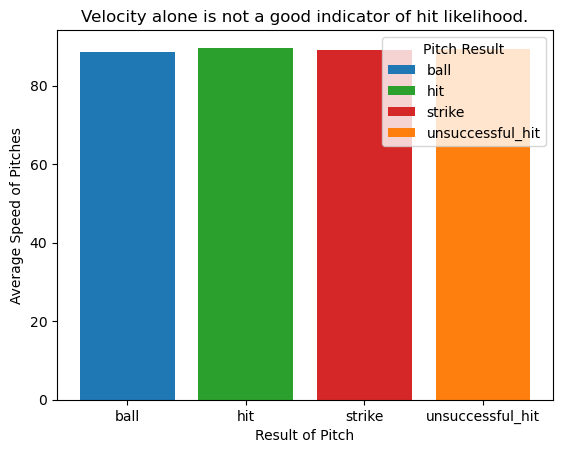

In [87]:
result = ['ball', 'hit', 'strike', 'unsuccessful_hit']
speeds = plot1['release_speed']

fig, ax = plt.subplots()

bar_labels = ['ball', 'hit', 'strike', 'unsuccessful_hit']
bar_colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange']


ax.bar(result, speeds, label=bar_labels, color=bar_colors)

ax.set_xlabel('Result of Pitch')
ax.set_ylabel('Average Speed of Pitches')
ax.set_title('Velocity alone is not a good indicator of hit likelihood.')
ax.legend(title='Pitch Result')

plt.show()

### By itself, spin rate is not a good predictor of hit likelihood.

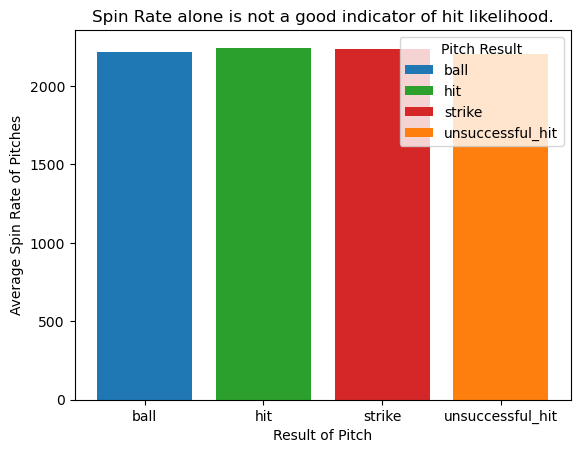

In [89]:
result = ['ball', 'hit', 'strike', 'unsuccessful_hit']
speeds = plot1['release_spin_rate']

fig, ax = plt.subplots()

bar_labels = ['ball', 'hit', 'strike', 'unsuccessful_hit']
bar_colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange']


ax.bar(result, speeds, label=bar_labels, color=bar_colors)

ax.set_xlabel('Result of Pitch')
ax.set_ylabel('Average Spin Rate of Pitches')
ax.set_title('Spin Rate alone is not a good indicator of hit likelihood.')
ax.legend(title='Pitch Result')

plt.show()

### Even after grouping by pitch type, velocity does not reliably tell us if a pitch will result in a hit or not.

In [232]:
plot2 = soto_stats.groupby(['pitch_type', 'result']).mean()[['release_speed', 'release_spin_rate']].reset_index()

smallest_subset = list(set(plot2[plot2['result'] == 'ball']['pitch_type']) & set(plot2[plot2['result'] == 'hit']['pitch_type'])\
& set(plot2[plot2['result'] == 'strike']['pitch_type']) & set(plot2[plot2['result'] == 'unsuccessful_hit']['pitch_type']))

plot2 = plot2[plot2['pitch_type'].isin(smallest_subset)] #some pitches do not have a single hit on record so i'm removing those

/var/folders/21/3pfj48b93_dfj5qvpfdk7v0h0000gn/T/ipykernel_78359/2213522357.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot2 = soto_stats.groupby(['pitch_type', 'result']).mean()[['release_speed', 'release_spin_rate']].reset_index()


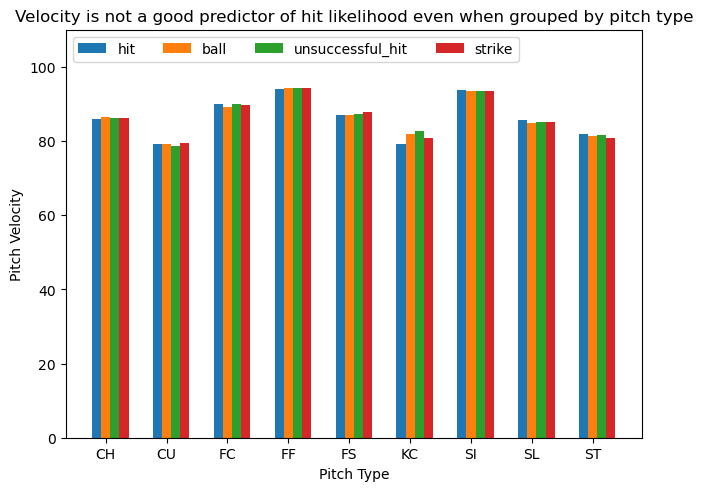

In [265]:
pitch_types = plot2['pitch_type'].unique()
pitch_speeds = {
    'hit': list(plot2[plot2['result'] == 'hit']['release_speed']),
    'ball': list(plot2[plot2['result'] == 'ball']['release_speed']),
    'unsuccessful_hit': list(plot2[plot2['result'] == 'unsuccessful_hit']['release_speed']),
    'strike': list(plot2[plot2['result'] == 'strike']['release_speed']),
    
}

x = np.arange(len(pitch_types))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in pitch_speeds.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_xlabel('Pitch Type')
ax.set_ylabel('Pitch Velocity')
ax.set_title('Velocity is not a good predictor of hit likelihood even when grouped by pitch type')
ax.set_xticks(x + width, pitch_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 110)

plt.show()

### Even after grouping by pitch type, spin rate does not reliably tell us if a pitch will result in a hit or not.

In [234]:
plot3 = soto_stats.groupby(['pitch_type', 'result']).mean()[['release_speed', 'release_spin_rate']].reset_index()

smallest_subset = list(set(plot3[plot3['result'] == 'ball']['pitch_type']) & set(plot3[plot3['result'] == 'hit']['pitch_type'])\
& set(plot3[plot3['result'] == 'strike']['pitch_type']) & set(plot3[plot3['result'] == 'unsuccessful_hit']['pitch_type']))

plot3 = plot3[plot3['pitch_type'].isin(smallest_subset)] #some pitches do not have a single hit on record so i'm removing those

/var/folders/21/3pfj48b93_dfj5qvpfdk7v0h0000gn/T/ipykernel_78359/1748500470.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot3 = soto_stats.groupby(['pitch_type', 'result']).mean()[['release_speed', 'release_spin_rate']].reset_index()


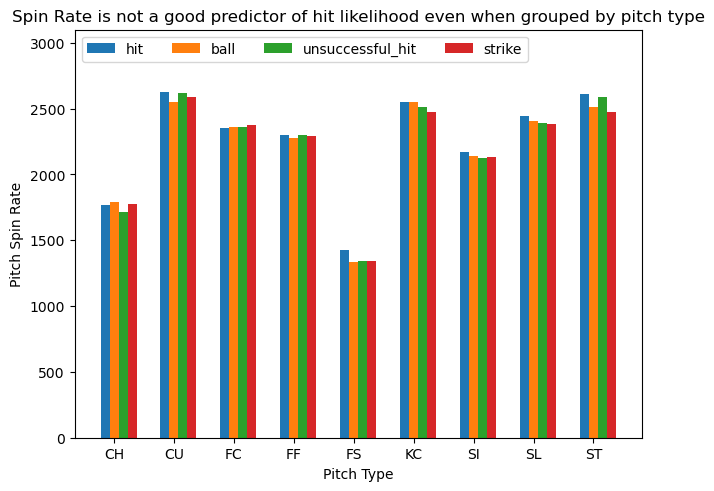

In [266]:
pitch_types = plot3['pitch_type'].unique()
pitch_speeds = {
    'hit': list(plot3[plot3['result'] == 'hit']['release_spin_rate']),
    'ball': list(plot3[plot3['result'] == 'ball']['release_spin_rate']),
    'unsuccessful_hit': list(plot3[plot3['result'] == 'unsuccessful_hit']['release_spin_rate']),
    'strike': list(plot3[plot3['result'] == 'strike']['release_spin_rate']),
}

x = np.arange(len(pitch_types))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in pitch_speeds.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_xlabel('Pitch Type')
ax.set_ylabel('Pitch Spin Rate')
ax.set_title('Spin Rate is not a good predictor of hit likelihood even when grouped by pitch type')
ax.set_xticks(x + width, pitch_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 3100)

plt.show()

### 5.20% of pitches from left hand pitchers are hits.

In [254]:
len(soto_stats[(soto_stats['result'] == 'hit') & (soto_stats['p_throws'] == 'L')])

101

In [255]:
  len(soto_stats[soto_stats['p_throws'] == 'L'])

1944

In [257]:
101/1944

0.051954732510288065

### 5.32% of pitches from right hand pitchers are hits.

In [259]:
len(soto_stats[(soto_stats['result'] == 'hit') & (soto_stats['p_throws'] == 'R')])

230

In [258]:
  len(soto_stats[soto_stats['p_throws'] == 'R'])

4322

In [261]:
230/4322

0.05321610365571495

# Notes

#### Variables to look at: 'release_speed', 'release_spin_rate', 'p_throws','pitch_type', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z'

predict woba based on location of pitch + pitch type 

### pitch type, location -> woba 
juan soto - curveball - 

1. pitcher's strengths (location + pitch type)
2. batter's weaknesses (location + pitch type)



- train model on velo, rpm, location, L/R, movement/break, pitch_type for a given batter
- take your pitcher's averages for velo, rpm, movement in the last month.
    - if we want generate a graph for how glasnow should pitch against soto
    - input all these pitcher averages into the model
    - we get a graph as output

generating a fastball graph for glasnow against soto:
input: glasnow's velo, rpm, location, L/R, movement/break, "fastball" 

glasnow's velo, rpm, location+0.1(change slightly everytime), L/R, movement/break, "fastball"
- change location everytime in order to sample every part of plate so we can graph



foul is better than swinging strike

## Old Work. Could use in the future.

#### Problem statement: Out of all swings, predict which ones will be a successful hit (i.e. single, double, triple, home run)
- Therefore, we only care about 'hit into play', 'foul', 'swinging_strike', 'foul_tip', 'missed_bunt', 'foul_bunt', and 'swinging_strike_blocked'

In [52]:
# soto_swings = soto_stats[(soto_stats['description'] == 'hit_into_play') | (soto_stats['description'] == 'foul') | \
# (soto_stats['description'] == 'swinging_strike') | (soto_stats['description'] == 'foul_tip') | \
# (soto_stats['description'] == 'missed_bunt') | (soto_stats['description'] == 'foul_bunt') | \
# (soto_stats['description'] == 'swinging_strike_blocked')]

# soto_swings

#### Events we care about: 'single', 'double', 'triple', 'home_run', 'fielders_choice'

In [53]:
#How many of the 1139 swings resulted in a successful swing(single, double, triple, HR)
soto_hits = soto_swings[(soto_swings['events'] == 'single') | (soto_swings['events'] == 'double') | \
(soto_swings['events'] == 'triple') | (soto_swings['events'] == 'home_run') | \
(soto_swings['events'] == 'fielders_choice')]

soto_hits

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
25,FC,2024-04-20,89.5,-2.22,5.79,"Soto, Juan",665742,621107,double,hit_into_play,...,0,0,0,0,0,Infield shade,Standard,209.0,0.037,0.231
30,CU,2024-04-20,79.4,-2.24,6.09,"Soto, Juan",665742,621107,single,hit_into_play,...,0,0,0,0,0,Infield shade,Standard,66.0,0.024,0.299
40,FF,2024-04-19,91.9,-0.07,6.51,"Soto, Juan",665742,606965,home_run,hit_into_play,...,1,1,5,5,1,Infield shade,Standard,213.0,0.149,2.279
46,FF,2024-04-17,96.5,-2.20,5.61,"Soto, Juan",665742,592332,double,hit_into_play,...,2,1,2,1,2,Standard,Standard,216.0,-0.115,1.047
48,SL,2024-04-17,85.2,-2.40,5.58,"Soto, Juan",665742,592332,single,hit_into_play,...,2,0,2,0,2,Standard,Standard,202.0,-0.042,0.420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,SI,2023-04-29,94.3,-1.84,5.70,"Soto, Juan",665742,596001,home_run,hit_into_play,...,8,8,6,6,8,NaN,NaN,244.0,0.091,0.933
3023,CU,2023-04-27,81.6,-1.40,5.97,"Soto, Juan",665742,624522,single,hit_into_play,...,5,1,5,1,5,Infield shade,Standard,31.0,-0.022,0.453
3086,SI,2023-04-23,95.8,-2.03,5.51,"Soto, Juan",665742,686753,single,hit_into_play,...,0,0,0,0,0,Infield shade,Standard,229.0,-0.086,0.633
3094,CU,2023-04-22,82.3,-1.63,5.64,"Soto, Juan",665742,518876,single,hit_into_play,...,3,2,3,2,3,Infield shade,Standard,58.0,-0.087,0.733


In [54]:
186/1139 * 100

16.330114135206323

#### 186 of 1139 swings were successful. 16.33% of Juan Soto's swings were successful in the past year.